Script 2:
- Model introduction
- Model performance
- Comparison between models

In [96]:
import pandas as pd
import numpy as np 
from numpy import loadtxt
import warnings
import os
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from imblearn.over_sampling import SMOTE, ADASYN

#from xgboost import XGBClassifier
from xgboost import plot_importance

import scipy.cluster.hierarchy as shc
#import lightgbm as lgb

# 1. Random Forest

### Import Data

In [7]:
df_modified = pd.read_csv('df_modified.csv')
display(df_modified.head(2))
display(df_modified.shape)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOCUMENT_SUM
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1.0,0.0,828.0,0.0,0.0,0.0,0.0,0.0,0.0,1


(307511, 53)

### Data Cleaning

In [8]:
# Convert Categorical Features into Numeric Features
ordinal_encoder = OrdinalEncoder()
cat_encoded=ordinal_encoder.fit_transform(df_modified.select_dtypes('object'))
df_cat_encoded=pd.DataFrame(cat_encoded,columns=df_modified.select_dtypes('object').columns)

# Normalize Numeric Data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df_modified.select_dtypes(include=numerics)
df_col = df_num.columns[2:]
transformer = Normalizer().fit(df_num.iloc[:,2:])
df_index = df_num.iloc[:,0:2]
df_num = pd.DataFrame(transformer.transform(df_num.iloc[:,2:]),columns=df_col)

# Combine Two Data
df_num= pd.concat([df_index, df_num], axis=1, sort=False)
df_modified= pd.concat([df_num, df_cat_encoded], axis=1, sort=False)

display(df_modified.head(2))
display(df_modified.shape)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,100002,1,0.0,0.352423,0.707626,0.042988,0.610866,3.272049e-08,0.000045,0.001109,...,0.0,1.0,6.0,7.0,4.0,3.0,1.0,8.0,6.0,5.0
1,100003,0,0.0,0.155288,0.743946,0.020532,0.649621,2.036573e-09,0.000026,0.000683,...,0.0,0.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,39.0


(307511, 53)

## 1.1 Base Model without Sampling

Our base model is the random forest model without sampling the original data.

In [12]:
# 1. Data Prepariation: denoting X and Y variable
Y = np.array(df_modified['TARGET'])
X = df_modified.drop('TARGET', axis = 1).iloc[:,1:]
feature = list(X.columns)
X = np.array(X) 

# 2. Split data into training and test set: 30% of data is test data, 70% of data is training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42) 

# 3. Train the Random Forest on Training Data
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, bootstrap=True, n_jobs=-1, min_samples_split=20, min_samples_leaf=10)
rf.fit(X_train, Y_train)

Y_pred = rf.predict(X_test)
Y_pred_prob = rf.predict_proba(X_test)


In [13]:
# AUC Score
metrics.roc_auc_score(Y_test, Y_pred)

0.5

In [14]:
# Confusion Matrix
confusion_matrix(Y_test, Y_pred)

array([[93362,     0],
       [ 8117,     0]])

In [19]:
Y_positive_prob = Y_pred_prob[:,1]
precision1, recall1, _ = precision_recall_curve(Y_test, Y_positive_prob)

Text(0.5,1,'Precision-Recall Curve: Original Data')

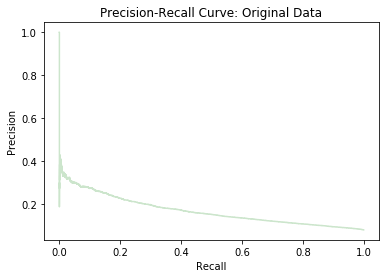

In [97]:
# Precision-Recall Curve
plt.step(recall1, precision1, color='g', alpha=0.2, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve: Original Data")

## 1.2 Base Model: Up Sampling

In [21]:
# 1. Data Prepariation: denoting X and Y variable
X = df_modified.drop('TARGET', axis = 1).iloc[:,1:]
Y = df_modified['TARGET']
feature = list(X.columns)

# 2. Split data into training and test set: 30% of data is test data, 70% of data is training 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [22]:
# Up Sampling the train data with the SMOTE
X_resampled, Y_resampled = SMOTE().fit_resample(X_train, Y_train)
X_resampled = pd.DataFrame(X_resampled,columns = X.columns)
Y_resampled = pd.DataFrame(Y_resampled,columns = ['TARGET'])

In [24]:
# 3. Train the Random Forest on Training Data
rf = RandomForestClassifier(n_estimators = 1000, random_state = 12,bootstrap=True,n_jobs=-1,class_weight='balanced',criterion='entropy' )
rf.fit(X_resampled, Y_resampled)

Y_pred = rf.predict(X_test)
Y_pred_prob = rf.predict_proba(X_test)

In [25]:
# AUC Score
metrics.accuracy_score(Y_test, Y_pred)

0.9033396072093733

In [26]:
# Confusion Matrix
confusion_matrix(Y_test, Y_pred)

array([[91177,  2185],
       [ 7624,   493]])

In [27]:
Y_positive_prob = Y_pred_prob[:,1]
precision2, recall2, _ = precision_recall_curve(Y_test, Y_positive_prob)

Text(0.5,1,'Precision-Recall Curve: Up Sampling')

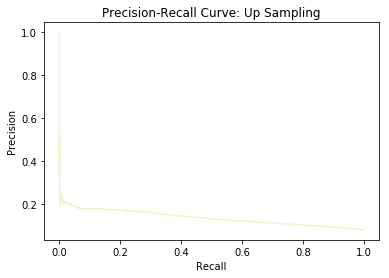

In [98]:
# Precision-Recall Curve
plt.step(recall2, precision2, color='y', alpha=0.2, where='post', label='Combined')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Up Sampling')

## 1.3 Base Model: Down Sampling

Since down sampling on the train data will lead to loss of information, we perform the down sampling for 10 times in Script 3 to get the average resutl. Since we only need one precision-recall curve here, we only perform 1 time of down sampling. The 1 time down sampling has similar result as the average 10 times down sampling.

In [30]:
# 1 Time Downsampling
# Count the number of Target 0 & 1
count0, count1 = df_modified.TARGET.value_counts()

# Split the Target 0 & 1
df_class0 = df_modified[df_modified['TARGET'] == 0]
df_class1 = df_modified[df_modified['TARGET'] == 1]

# Sample from Target 0
df_class0_resample = df_class0.sample(count1)

# Combine the Sampled Target 0 & Target 1
df_balance = pd.concat([df_class0_resample, df_class1], axis=0).reset_index(drop = True)

display(df_balance.head())
display(df_balance.shape)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,215797,0,0.000000,0.058806,0.705677,0.023715,0.705677,1.379573e-08,0.000033,0.000861,...,0.0,1.0,6.0,3.0,1.0,1.0,1.0,18.0,4.0,57.0
1,390117,0,0.000002,0.258841,0.715436,0.048080,0.647102,1.462655e-08,0.000092,0.003090,...,0.0,1.0,6.0,7.0,4.0,5.0,2.0,18.0,3.0,54.0
2,140346,0,0.000000,0.310328,0.718968,0.039182,0.620656,1.000056e-07,0.000034,0.001370,...,1.0,1.0,6.0,1.0,1.0,3.0,1.0,3.0,5.0,33.0
3,244358,0,0.000000,0.467394,0.703387,0.034227,0.534164,2.167816e-08,0.000169,0.004891,...,0.0,1.0,6.0,3.0,4.0,1.0,1.0,18.0,4.0,57.0
4,440893,0,0.000000,0.061843,0.734034,0.018556,0.676031,8.152679e-09,0.000013,0.002530,...,0.0,0.0,6.0,4.0,1.0,1.0,1.0,10.0,0.0,28.0


(49650, 53)

In [31]:
# Random Forest
# 1. Data Prepariation
Y = np.array(df_balance['TARGET'])
X = df_balance.drop('TARGET', axis = 1).iloc[:,1:]
feature = list(X.columns)
X = np.array(X) 

# 2. Split data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42) 

# 3. Train the Random Forest on Training Data
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, bootstrap=True, n_jobs=-1, min_samples_split=20, min_samples_leaf=10)
rf.fit(X_train, Y_train)

Y_pred = rf.predict(X_test)
Y_pred_prob = rf.predict_proba(X_test)

In [32]:
# AUC score
metrics.roc_auc_score(Y_test, Y_pred)

0.640174621733566

In [33]:
# Confusion Matrix
confusion_matrix(Y_test, Y_pred)

array([[5463, 2744],
       [3151, 5027]])

In [34]:
Y_positive_prob = Y_pred_prob[:,1]
precision3, recall3, _ = precision_recall_curve(Y_test, Y_positive_prob)

Text(0.5,1,'Precision-Recall Curve: Down Sampling')

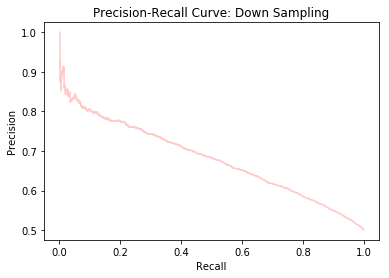

In [99]:
# Precision-Recall Curve
plt.step(recall3, precision3, color='r', alpha=0.2, where='post', label='Down Sampling')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Down Sampling')

## Comparison between Base Models

Text(0.5,1,'Precision-Recall Curve for Random Forest Base Models')

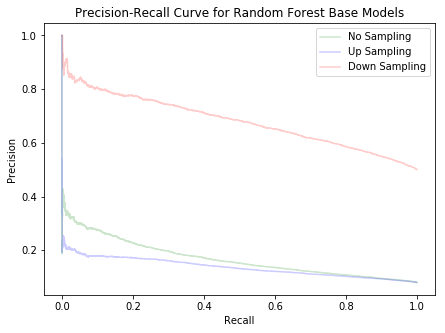

In [81]:
plt.figure(figsize=(7,5))

# Precision-Recall Curve
plt.step(recall1, precision1, color='g', alpha=0.2, where='post', label='No Sampling')
plt.step(recall2, precision2, color='b', alpha=0.2, where='post', label='Up Sampling')
plt.step(recall3, precision3, color='r', alpha=0.2, where='post', label='Down Sampling')

plt.legend(loc='upper right')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Base Models')

After comparison, our final base Random Forest model is the model with sampling. 

### Import New Data

Since the originial data does not have enough features to help the classficiation, we added other datasets to our main dataset, dropped the features with zero feature importance score and combined class of categorical features. 

In [62]:
df_combined = pd.read_csv('combined_clean.csv')

df_combined.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,STATUS_C_PERC,STATUS_X_PERC,STATUS_2_TO_4_PERC,CHILDREN_RATIO,INCOME_PER_CHLD,EMPLOYED_BIRTH_RATIO,LOAN_INCOME_RATIO,ANNUITY_LENGTH,INCOME_PER_PERSON,ANNUITY_INCOME_PERC
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.209091,0.136364,0.0,0.0,202500.0,0.067329,2.007889,16.461104,12.218500,0.349252
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.000000,1.000000,0.0,0.0,270000.0,0.070862,4.790750,36.234085,11.813037,0.363615
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.000000,1.000000,0.0,0.0,67500.0,0.011814,2.000000,20.000000,11.119898,0.316225
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.000000,1.000000,0.0,0.0,135000.0,0.159905,2.316167,10.532818,11.119898,0.468933
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.000000,1.000000,0.0,0.0,121500.0,0.152418,4.222222,23.461618,11.707678,0.424219


### Data Cleaning

In [63]:
# 1. Feature Selection: Remove the feature with zero feature importance score
selected_feature = pd.read_csv('random_forest_selection 2.csv')

df_combined = df_combined[[col for col in df_combined.columns if col in selected_feature['0'].tolist()]]

df_combined.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,STATUS_0_PERC,STATUS_C_PERC,STATUS_X_PERC,CHILDREN_RATIO,INCOME_PER_CHLD,EMPLOYED_BIRTH_RATIO,LOAN_INCOME_RATIO,ANNUITY_LENGTH,INCOME_PER_PERSON,ANNUITY_INCOME_PERC
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.409091,0.209091,0.136364,0.0,202500.0,0.067329,2.007889,16.461104,12.218500,0.349252
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.000000,0.000000,1.000000,0.0,270000.0,0.070862,4.790750,36.234085,11.813037,0.363615
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.000000,0.000000,1.000000,0.0,67500.0,0.011814,2.000000,20.000000,11.119898,0.316225
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.000000,0.000000,1.000000,0.0,135000.0,0.159905,2.316167,10.532818,11.119898,0.468933
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.000000,0.000000,1.000000,0.0,121500.0,0.152418,4.222222,23.461618,11.707678,0.424219


In [64]:
# 2. Change categorical variable
ordinal_encoder = OrdinalEncoder()
cat_encoded = ordinal_encoder.fit_transform(df_combined.select_dtypes('object'))
df_cat_encoded = pd.DataFrame(cat_encoded, columns = df_combined.select_dtypes('object').columns)

# 3. Normalize numeric variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df_combined.select_dtypes(include = numerics)
df_col = df_num.columns[2:]
transformer = Normalizer().fit(df_num.iloc[:,2:])
df_index = df_num.iloc[:,0:2]
df_num = pd.DataFrame(transformer.transform(df_num.iloc[:,2:]),columns=df_col)

# 4. Combine Data
df_num= pd.concat([df_index, df_num], axis=1, sort=False)
df_combined = pd.concat([df_num, df_cat_encoded], axis=1, sort=False) 

display(df_combined.head())
display(df_combined.shape)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NAME_CLIENT_TYPE_Pre,NAME_GOODS_CATEGORY_Pre,NAME_PORTFOLIO_Pre,NAME_PRODUCT_TYPE_Pre,CHANNEL_TYPE_Pre,NAME_SELLER_INDUSTRY_Pre,NAME_YIELD_GROUP_Pre,PRODUCT_COMBINATION_Pre,CREDIT_ACTIVE_MAX,CREDIT_TYPE_MAX
0,100002,1,0.0,0.191107,0.383721,0.023311,0.331252,0.000025,0.000601,0.003443,...,0.0,23.0,3.0,0.0,7.0,0.0,29.0,15.0,2.0,3.0
1,100003,0,0.0,0.061659,0.295393,0.008152,0.257940,0.000011,0.000271,0.000271,...,1.0,1361.0,3.0,0.0,107.0,243.0,30.0,3605.0,2.0,3.0
2,100004,0,0.0,0.270375,0.540750,0.027037,0.540750,0.000208,0.000901,0.017064,...,0.0,17.0,3.0,0.0,6.0,2.0,30.0,14.0,2.0,2.0
3,100006,0,0.0,0.025084,0.058099,0.005516,0.055185,0.000010,0.000565,0.001827,...,2.0,25.0,27.0,0.0,5.0,10.0,0.0,4315.0,4.0,12.0
4,100007,0,0.0,0.055153,0.232867,0.009925,0.232867,0.000025,0.001379,0.001957,...,2.0,25.0,2.0,6.0,4.0,4.0,22.0,8.0,2.0,2.0


(307511, 263)

## 1.4 Improved Model: Up Sampling

In [65]:
# 1. Data Prepariation: denoting X and Y variable
X = df_combined.drop('TARGET', axis = 1).iloc[:,1:]
Y = df_combined['TARGET']
feature = list(X.columns)

# 2. Split data into training and test set: 30% of data is test data, 70% of data is training 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [66]:
# Up Sampling
X_resampled, Y_resampled = SMOTE().fit_resample(X_train, Y_train)
X_resampled = pd.DataFrame(X_resampled,columns = X.columns)
Y_resampled = pd.DataFrame(Y_resampled,columns = ['TARGET'])

In [67]:
X_resampled.shape

(378648, 261)

In [68]:
# 3. Train the Random Forest on Training Data
rf = RandomForestClassifier(n_estimators = 1000, random_state = 12,bootstrap=True,n_jobs=-1,class_weight='balanced',criterion='entropy' )
rf.fit(X_resampled, Y_resampled)

Y_pred = rf.predict(X_test)
Y_pred_prob = rf.predict_proba(X_test)

In [69]:
# AUC Socre
metrics.accuracy_score(Y_test, Y_pred)

0.9100207924792322

In [70]:
# Confusion Matrix
confusion_matrix(Y_test, Y_pred)

array([[91992,  1370],
       [ 7761,   356]])

In [71]:
Y_positive_prob = Y_pred_prob[:,1]
precision4, recall4, _ = precision_recall_curve(Y_test, Y_positive_prob)

Text(0.5,1,'Precision-Recall Curve: Improved Up Sampling')

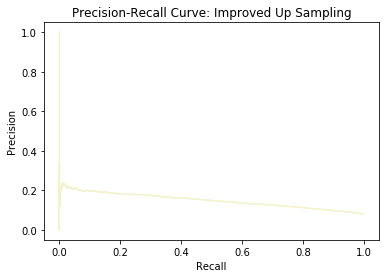

In [73]:
# Precision-Recall Curve
plt.step(recall4, precision4, color='y', alpha=0.2, where='post', label='Up Sampling')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Improved Up Sampling')

## 1.5 Improved Model: Down Sampling

In [88]:
# 1 Time Down Sampling
# Count the number of Target 0 & 1
count0, count1 = df_combined.TARGET.value_counts()

# Split the Target 0 & 1
df_class0 = df_combined[df_combined['TARGET'] == 0]
df_class1 = df_combined[df_combined['TARGET'] == 1]

# Sample from Target 0
df_class0_resample = df_class0.sample(count1)

# Combine the Sampled Target 0 & Target 1
df_balance = pd.concat([df_class0_resample, df_class1], axis=0).reset_index(drop = True)

display(df_balance.head())
display(df_balance.shape)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_ANNUITY_Pre_mean,AMT_APPLICATION_Pre_mean,AMT_CREDIT_Pre_mean,AMT_GOODS_PRICE_Pre_mean,HOUR_APPR_PROCESS_START_Pre_mean,NFLAG_LAST_APPL_IN_DAY_Pre_mean,DAYS_DECISION_Pre_mean,SELLERPLACE_AREA_Pre_mean,CNT_PAYMENT_Pre_mean,AMT_ANNUITY_Pre_min,AMT_APPLICATION_Pre_min,AMT_CREDIT_Pre_min,AMT_GOODS_PRICE_Pre_min,HOUR_APPR_PROCESS_START_Pre_min,NFLAG_LAST_APPL_IN_DAY_Pre_min,DAYS_DECISION_Pre_min,SELLERPLACE_AREA_Pre_min,CNT_PAYMENT_Pre_min,AMT_ANNUITY_Pre_max,AMT_APPLICATION_Pre_max,AMT_CREDIT_Pre_max,AMT_GOODS_PRICE_Pre_max,HOUR_APPR_PROCESS_START_Pre_max,NFLAG_LAST_APPL_IN_DAY_Pre_max,DAYS_DECISION_Pre_max,SELLERPLACE_AREA_Pre_max,CNT_PAYMENT_Pre_max,AMT_ANNUITY_Pre_sum,AMT_APPLICATION_Pre_sum,AMT_CREDIT_Pre_sum,AMT_GOODS_PRICE_Pre_sum,HOUR_APPR_PROCESS_START_Pre_sum,NFLAG_LAST_APPL_IN_DAY_Pre_sum,DAYS_DECISION_Pre_sum,SELLERPLACE_AREA_Pre_sum,CNT_PAYMENT_Pre_sum,DAYS_INSTALMENT_Ins_mean,DAYS_ENTRY_PAYMENT_Ins_mean,AMT_INSTALMENT_Ins_mean,AMT_PAYMENT_Ins_mean,Own_payment_Ins_mean,payday_before_dueday_Ins_mean,DAYS_INSTALMENT_Ins_min,DAYS_ENTRY_PAYMENT_Ins_min,AMT_INSTALMENT_Ins_min,AMT_PAYMENT_Ins_min,Own_payment_Ins_min,payday_before_dueday_Ins_min,DAYS_INSTALMENT_Ins_max,DAYS_ENTRY_PAYMENT_Ins_max,AMT_INSTALMENT_Ins_max,AMT_PAYMENT_Ins_max,Own_payment_Ins_max,payday_before_dueday_Ins_max,DAYS_INSTALMENT_Ins_sum,DAYS_ENTRY_PAYMENT_Ins_sum,AMT_INSTALMENT_Ins_sum,AMT_PAYMENT_Ins_sum,Own_payment_Ins_sum,payday_before_dueday_Ins_sum,MONTHS_BALANCE_Cre_mean,AMT_BALANCE_Cre_mean,AMT_CREDIT_LIMIT_ACTUAL_Cre_mean,AMT_DRAWINGS_ATM_CURRENT_Cre_mean,AMT_DRAWINGS_CURRENT_Cre_mean,AMT_DRAWINGS_OTHER_CURRENT_Cre_mean,AMT_DRAWINGS_POS_CURRENT_Cre_mean,AMT_INST_MIN_REGULARITY_Cre_mean,AMT_PAYMENT_CURRENT_Cre_mean,AMT_PAYMENT_TOTAL_CURRENT_Cre_mean,AMT_RECEIVABLE_PRINCIPAL_Cre_mean,AMT_RECIVABLE_Cre_mean,AMT_TOTAL_RECEIVABLE_Cre_mean,CNT_DRAWINGS_ATM_CURRENT_Cre_mean,CNT_DRAWINGS_CURRENT_Cre_mean,CNT_DRAWINGS_POS_CURRENT_Cre_mean,CNT_INSTALMENT_MATURE_CUM_Cre_mean,SK_DPD_Cre_mean,MONTHS_BALANCE_Cre_min,AMT_BALANCE_Cre_min,AMT_CREDIT_LIMIT_ACTUAL_Cre_min,AMT_DRAWINGS_ATM_CURRENT_Cre_min,AMT_DRAWINGS_CURRENT_Cre_min,AMT_DRAWINGS_POS_CURRENT_Cre_min,AMT_INST_MIN_REGULARITY_Cre_min,AMT_PAYMENT_CURRENT_Cre_min,AMT_PAYMENT_TOTAL_CURRENT_Cre_min,AMT_RECEIVABLE_PRINCIPAL_Cre_min,AMT_RECIVABLE_Cre_min,AMT_TOTAL_RECEIVABLE_Cre_min,CNT_DRAWINGS_ATM_CURRENT_Cre_min,CNT_DRAWINGS_CURRENT_Cre_min,CNT_DRAWINGS_POS_CURRENT_Cre_min,CNT_INSTALMENT_MATURE_CUM_Cre_min,MONTHS_BALANCE_Cre_max,AMT_BALANCE_Cre_max,AMT_CREDIT_LIMIT_ACTUAL_Cre_max,AMT_DRAWINGS_ATM_CURRENT_Cre_max,AMT_DRAWINGS_CURRENT_Cre_max,AMT_DRAWINGS_OTHER_CURRENT_Cre_max,AMT_DRAWINGS_POS_CURRENT_Cre_max,AMT_INST_MIN_REGULARITY_Cre_max,AMT_PAYMENT_CURRENT_Cre_max,AMT_PAYMENT_TOTAL_CURRENT_Cre_max,AMT_RECEIVABLE_PRINCIPAL_Cre_max,AMT_RECIVABLE_Cre_max,AMT_TOTAL_RECEIVABLE_Cre_max,CNT_DRAWINGS_ATM_CURRENT_Cre_max,CNT_DRAWINGS_CURRENT_Cre_max,CNT_DRAWINGS_OTHER_CURRENT_Cre_max,CNT_DRAWINGS_POS_CURRENT_Cre_max,CNT_INSTALMENT_MATURE_CUM_Cre_max,SK_DPD_Cre_max,SK_DPD_DEF_Cre_max,MONTHS_

(49650, 263)

In [89]:
# Random Forest
# 1. Data Prepariation
Y = np.array(df_balance['TARGET'])
X = df_balance.drop('TARGET', axis = 1).iloc[:,1:]
feature = list(X.columns)
X = np.array(X) 

# 2. Split data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42) 

# 3. Train the Random Forest on Training Data
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, bootstrap=True, n_jobs=-1, min_samples_split=20, min_samples_leaf=10)
rf.fit(X_train, Y_train)

Y_pred = rf.predict(X_test)
Y_pred_prob = rf.predict_proba(X_test)

In [90]:
# AUC Socre
metrics.accuracy_score(Y_test, Y_pred)

0.6563320109856576

In [91]:
# Confusion Matrix
confusion_matrix(Y_test, Y_pred)

array([[5494, 2713],
       [2918, 5260]])

In [92]:
Y_positive_prob = Y_pred_prob[:,1]
precision5, recall5, _ = precision_recall_curve(Y_test, Y_positive_prob)

Text(0.5,1,'Precision-Recall Curve: Improved Down Sampling')

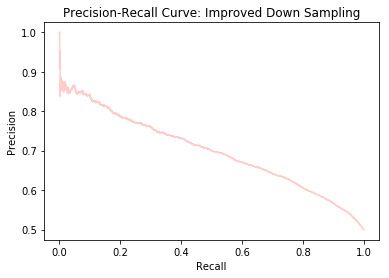

In [93]:
# Precision-Recall Curve
plt.step(recall5, precision5, color='r', alpha=0.2, where='post', label='Down Sampling')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Improved Down Sampling')

## Model Comparison: Base vs. Final

Text(0.5,1,'Precision-Recall Curve')

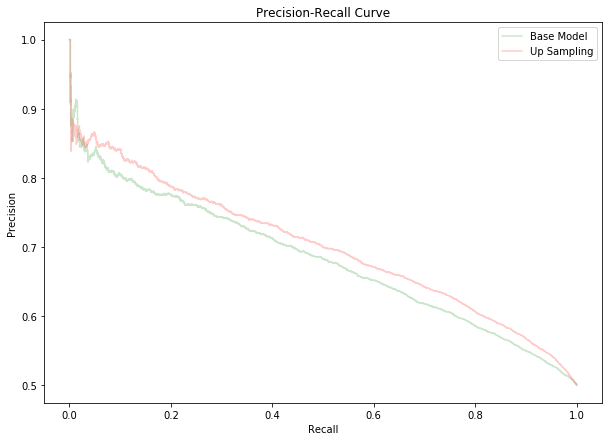

In [94]:
plt.figure(figsize=(10,7))

# Precision-Recall Curve
plt.step(recall3, precision3, color='g', alpha=0.2, where='post', label='Base Model')
plt.step(recall5, precision5, color='r', alpha=0.2, where='post', label='Up Sampling')

plt.legend(loc='upper right')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

## Based Data Preprocessing

In [4]:
# Change Categorical Variable
ordinal_encoder = OrdinalEncoder()
cat_encoded=ordinal_encoder.fit_transform(df_modified.select_dtypes('object'))
df_cat_encoded=pd.DataFrame(cat_encoded,columns=df_modified.select_dtypes('object').columns)


# Normalize Numeric Data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df_modified.select_dtypes(include=numerics)
df_col = df_num.columns[2:]
transformer = Normalizer().fit(df_num.iloc[:,2:])
df_index = df_num.iloc[:,0:2]
df_num = pd.DataFrame(transformer.transform(df_num.iloc[:,2:]),columns=df_col)


# Combine Numeric and Categorical Data
df_num= pd.concat([df_index, df_num], axis=1, sort=False)
base_model= pd.concat([df_num, df_cat_encoded], axis=1, sort=False)

In [5]:
X = base_model.drop('TARGET', axis = 1).iloc[:,1:]
Y = base_model['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Final Data Preprocessing

In [6]:
# Change Categorical Variable
ordinal_encoder = OrdinalEncoder()
cat_encoded=ordinal_encoder.fit_transform(df_combined.select_dtypes('object'))
df_cat_encoded=pd.DataFrame(cat_encoded,columns=df_combined.select_dtypes('object').columns)


# Normalize Numeric Data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df_combined.select_dtypes(include=numerics)
df_col = df_num.columns[2:]
transformer = Normalizer().fit(df_num.iloc[:,2:])
df_index = df_num.iloc[:,0:2]
df_num = pd.DataFrame(transformer.transform(df_num.iloc[:,2:]),columns=df_col)


# Combine Numeric and Categorical Data
df_num= pd.concat([df_index, df_num], axis=1, sort=False)
final_model= pd.concat([df_num, df_cat_encoded], axis=1, sort=False)

In [7]:
X1 = final_model.drop('TARGET', axis = 1).iloc[:,1:]
Y1 = final_model['TARGET']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.33, random_state=42)

# 2. SVM

## 2.1 SVM Base Model

In [ ]:
#svm with linear kernel
svml = LinearSVC(random_state=0, tol=1e-5)
svml.fit(X_resampled, y_resampled) 

y_svm_pred=svml.predict(X_test)
print(accuracy_score(y_test,y_svm_pred))
confusion_matrix(y_test,y_svm_pred)

## 2.2 SVM Final Model

In [ ]:
#svm with rbf kernel
svm = SVC(gamma='auto',C=2)
svm.fit(X_resampled, y_resampled)

svm_pred=svm.predict(X_test)
confusion_matrix(y_test,svm_pred)

accuracy_score(y_test,svm_pred)

# 3. KNN

## 3.1 KNN Base Model

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, Y_train)
knn_pred=neigh.predict(X_test)
display(metrics.accuracy_score(Y_test,knn_pred))
display(metrics.roc_auc_score(Y_test,knn_pred))
display(confusion_matrix(Y_test,knn_pred))

## 3.2 KNN Final Model

In [ ]:
neigh1 = KNeighborsClassifier(n_neighbors=5)
neigh1.fit(X_train1, Y_train1)
knn_pred1=neigh1.predict(X_test1)
display(metrics.accuracy_score(y_test1, knn_pred1))
display(metrics.roc_auc_score(y_test1, knn_pred1))
display(confusion_matrix(y_test1, knn_pred1))

# 4. XGBoost

## 4.1 XGBoost Base Model

In [ ]:
X_resampled, Y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled = pd.DataFrame(X_resampled,columns = X.columns)
Y_resampled = pd.DataFrame(Y_resampled,columns = ['TARGET'])

In [10]:
xgb = XGBClassifier(objective = 'binary:logistic', booster = "gbtree", eval_metric = 'auc'
                    ,nrounds = 100, n_estimators=200, nthread = 4,
                   random_state = 42)
xgb.fit(X_resampled,Y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nrounds=100, nthread=4,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [11]:
y_pred = xgb.predict(X_test)
y_pred[y_pred<=0.5]=0
y_pred[y_pred>0.5]=1

In [12]:
display(metrics.roc_auc_score(y_test, y_pred))
display(metrics.roc_auc_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.544301268267688

0.544301268267688

array([[89695,  3667],
       [ 7079,  1038]])

## 4.2 XGBoost Final Model

In [17]:
X_resampled1, Y_resampled1 = SMOTE().fit_resample(X_train1, y_train1)
X_resampled1 = pd.DataFrame(X_resampled1,columns = X1.columns)
Y_resampled1 = pd.DataFrame(Y_resampled1,columns = ['TARGET'])

In [18]:
xgb1 = XGBClassifier(objective = 'binary:logistic', booster = "gbtree", eval_metric = 'auc'
                    ,nrounds = 100, n_estimators=200, nthread = 4,
                   random_state = 42)
xgb1.fit(X_resampled1,Y_resampled1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nrounds=100, nthread=4,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [19]:
y_pred = xgb1.predict(X_test1)
y_pred[y_pred<=0.5]=0
y_pred[y_pred>0.5]=1

In [20]:
display(metrics.roc_auc_score(y_test1, y_pred))
display(metrics.roc_auc_score(y_test1, y_pred))
confusion_matrix(y_test1, y_pred)

0.5121167273592752

0.5121167273592752

array([[92887,   475],
       [ 7879,   238]])

# 5. LightGBM

## 5.1 LightGBM Base Model

In [46]:
df_mod=df_modified

In [47]:
d_train = lgb.Dataset(df_mod.drop(['TARGET'],axis=1,inplace=False), label=df_mod['TARGET'])

In [48]:
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = ['auc','binary_logloss','binary_error']
params['stratified']=True 
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
params['seed'] = 0
params['eval_train_metric'] = True
params['lass_weight'] = 'balanced' 

In [ ]:
Y = df_mod['TARGET']
X = df_mod.copy()
X.drop(columns=['TARGET'],inplace=True)

feature = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
# Up Sampling
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled=pd.DataFrame(X_resampled,columns=X.columns)
y_resampled=pd.DataFrame(y_resampled,columns=['TARGET'])

In [ ]:
train_data_rs = lgb.Dataset(X_resampled, label=y_resampled)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [39]:
start_time_lgbm = time.clock()
lgb_n= lgb.train(params,train_data,
                       valid_sets=test_data,
                       num_boost_round=1000,
                       early_stopping_rounds=100)
end_time_lgb=time.clock() - start_time_lgbm

[1]	valid_0's auc: 0.617416	valid_0's binary_logloss: 0.278684	valid_0's binary_error: 0.079987
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.644083	valid_0's binary_logloss: 0.278615	valid_0's binary_error: 0.079987
[3]	valid_0's auc: 0.647903	valid_0's binary_logloss: 0.278548	valid_0's binary_error: 0.079987
[4]	valid_0's auc: 0.652195	valid_0's binary_logloss: 0.278477	valid_0's binary_error: 0.079987
[5]	valid_0's auc: 0.65261	valid_0's binary_logloss: 0.278412	valid_0's binary_error: 0.079987
[6]	valid_0's auc: 0.653766	valid_0's binary_logloss: 0.278342	valid_0's binary_error: 0.079987
[7]	valid_0's auc: 0.66116	valid_0's binary_logloss: 0.278298	valid_0's binary_error: 0.079987
[8]	valid_0's auc: 0.661352	valid_0's binary_logloss: 0.27823	valid_0's binary_error: 0.079987
[9]	valid_0's auc: 0.671675	valid_0's binary_logloss: 0.278171	valid_0's binary_error: 0.079987
[10]	valid_0's auc: 0.669858	valid_0's binary_logloss: 0.278104	valid_0's bi

[86]	valid_0's auc: 0.683703	valid_0's binary_logloss: 0.274288	valid_0's binary_error: 0.079987
[87]	valid_0's auc: 0.683486	valid_0's binary_logloss: 0.274241	valid_0's binary_error: 0.079987
[88]	valid_0's auc: 0.68356	valid_0's binary_logloss: 0.274188	valid_0's binary_error: 0.079987
[89]	valid_0's auc: 0.683447	valid_0's binary_logloss: 0.274155	valid_0's binary_error: 0.079987
[90]	valid_0's auc: 0.683577	valid_0's binary_logloss: 0.274112	valid_0's binary_error: 0.079987
[91]	valid_0's auc: 0.68363	valid_0's binary_logloss: 0.274066	valid_0's binary_error: 0.079987
[92]	valid_0's auc: 0.684064	valid_0's binary_logloss: 0.274033	valid_0's binary_error: 0.079987
[93]	valid_0's auc: 0.684288	valid_0's binary_logloss: 0.273989	valid_0's binary_error: 0.079987
[94]	valid_0's auc: 0.68447	valid_0's binary_logloss: 0.273954	valid_0's binary_error: 0.079987
[95]	valid_0's auc: 0.684442	valid_0's binary_logloss: 0.273918	valid_0's binary_error: 0.079987
[96]	valid_0's auc: 0.684482	vali

In [42]:
lgb_n.best_score

defaultdict(dict,
            {'valid_0': {'auc': 0.6174160286753511,
              'binary_logloss': 0.2786842446240509,
              'binary_error': 0.07998699238266045}})

In [45]:
# Accuracy Rate
accuracy_score(y_pred_lgb,y_test)

0.9200130076173395

In [43]:
# Confusion Matrix
confusion_matrix(y_pred_lgb,y_test)

array([[93362,  8117],
       [    0,     0]], dtype=int64)

## 5.2 LightGBM: Sklearn Format with Main Data

In [36]:
start_time_lgbm_rs = time.clock()
sk_lgb=lgb.LGBMClassifier(n_estimators=1000,boosting_type='gbdt',random_state=0)
#sk_lgb.fit(X_resampled.values, y_resampled.values)
sk_lgb.fit(X_train.values, y_train.values)
end_time_lgbm_rs=time.clock() - start_time_lgbm_rs

Y_pred_sk = sk_lgb.predict(X_test)

In [37]:
end_time_lgbm_rs

24.2588605415076

In [39]:
# Accuracy Rate
accuracy_score(Y_pred_sk,y_test)

0.9191556873835967

In [40]:
# AUC Score
y_pred_proba_lgbmsk =sk_lgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_lgbmsk)
auc_rf_lgbmsk = metrics.roc_auc_score(y_test, y_pred_proba_lgbmsk)
auc_rf_lgbmsk

0.7304234816362317

In [38]:
# Confusion Matrix
confusion_matrix(Y_pred_sk,y_test)

array([[93067,  7909],
       [  295,   208]], dtype=int64)

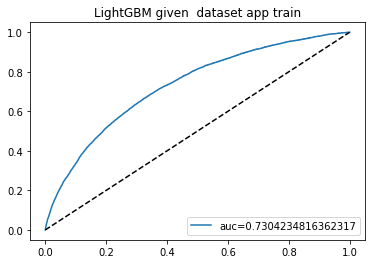

In [41]:
# ROC Curve
plt.plot(fpr,tpr,label="auc="+str(auc_rf_lgbmsk))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('LightGBM given  dataset app train')
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve:LightGBM given  dataset app train: AP=0.20')

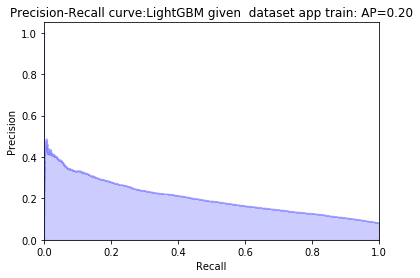

In [42]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbmsk )
average_precision = average_precision_score(y_test,y_pred_proba_lgbmsk )
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:LightGBM given  dataset app train: AP={0:0.2f}'.format(
          average_precision))

## 5.3 LightGBM: Up Sampling

In [43]:
start_time_lgbm_rs = time.clock()
lgbm= lgb.LGBMClassifier(n_estimators=1000,boosting_type='gbdt',random_state=0)
lgbm.fit(X_resampled.values, y_resampled.values)
end_time_lgbm_rs=time.clock() - start_time_lgbm_rs

In [44]:
end_time_lgbm_rs

103.91513920000034

In [52]:
y_pred_lgbm = lgbm.predict(X_test)

In [53]:
# Accuracy Rate
accuracy_score(y_pred_lgbm,y_test)

0.9190078735501926

In [55]:
# AUC Score
y_pred_proba_lgbm =lgbm.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_lgbm)
auc_rf_lgbm = metrics.roc_auc_score(y_test, y_pred_proba_lgbm)
auc_rf_lgbm

0.7522899487732005

In [54]:
# Confusion Matrix
confusion_matrix(y_pred_lgbm,y_test)

array([[92831,  7688],
       [  531,   429]], dtype=int64)

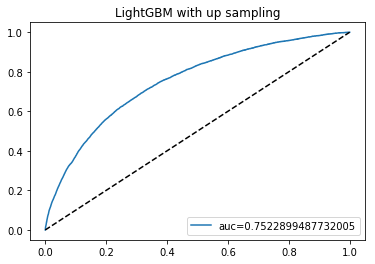

In [56]:
# ROC Curve
plt.plot(fpr,tpr,label="auc="+str(auc_rf_lgbm))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('LightGBM with up sampling')
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve:LightGBM with up sampling: AP=0.23')

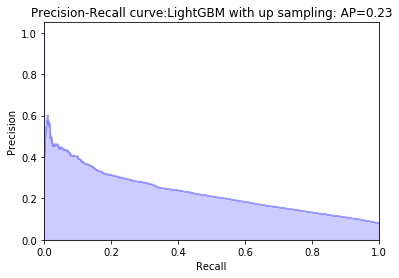

In [57]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbm )
average_precision = average_precision_score(y_test,y_pred_proba_lgbm )
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:LightGBM with up sampling: AP={0:0.2f}'.format(
          average_precision))

## 5.4 LightGBM: Combined Data

In [71]:
start_time_lgbm_rs = time.clock()
sk_lgb=lgb.LGBMClassifier(n_estimators=1000,boosting_type='gbdt',random_state=0)
#sk_lgb.fit(X_resampled.values, y_resampled.values)
sk_lgb.fit(X_train.values, y_train.values)
end_time_lgbm_rs=time.clock() - start_time_lgbm_rs

Y_pred_sk = sk_lgb.predict(X_test)

In [72]:
end_time_lgbm_rs

55.44553860000087

In [27]:
y_pred_proba_lgbmsk =sk_lgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_lgbmsk)
auc_rf_lgbmsk = metrics.roc_auc_score(y_test, y_pred_proba_lgbmsk)
auc_rf_lgbmsk

0.7549517018537376

In [26]:
# Accuracy Rate
accuracy_score(Y_pred_sk,y_test)

0.9194513150504046

In [25]:
# Confusion Matrix
confusion_matrix(Y_pred_sk,y_test)

array([[92913,  7725],
       [  449,   392]], dtype=int64)

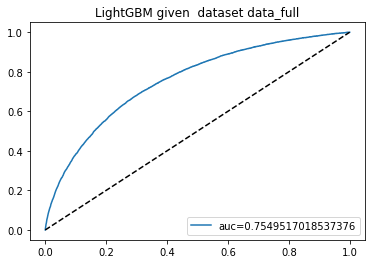

In [28]:
# ROC Curve
plt.plot(fpr,tpr,label="auc="+str(auc_rf_lgbmsk))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('LightGBM given  dataset data_full')
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve:LightGBM given  dataset data_full: AP=0.24')

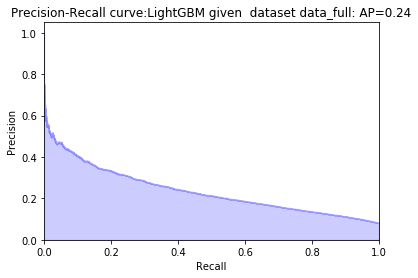

In [29]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbmsk )
average_precision = average_precision_score(y_test,y_pred_proba_lgbmsk )
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:LightGBM given  dataset data_full: AP={0:0.2f}'.format(
          average_precision))

# 6. Voting Classifier

## 6.1 Voting Classifier: KNN

In [28]:
start_time_knn_bag = time.clock()
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=5),n_estimators=10,n_jobs=-1,random_state=0) # due to the memory issue, we can only use 30 estimators
bagging.fit(X_train, y_train) 
end_time_knn_bag=time.clock() - start_time_knn_bag
end_time_knn_bag

232.164941

In [29]:
start_time_knn_bag_pred = time.clock()
y_pred_bag = bagging.predict(X_test)
end_time_knn_bag_pred=time.clock() - start_time_knn_bag_pred
print(end_time_knn_bag_pred)
accuracy_score(y_test,y_pred_bag)

121.17794120000053


0.9159727628376314

In [30]:
# AUC Score
y_pred_proba_knn_bag =bagging.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn_bag)
auc_knn_bag = metrics.roc_auc_score(y_test, y_pred_proba_knn_bag)
auc_knn_bag

0.5065119378041115

In [31]:
# Confusion Matrix
confusion_matrix(y_test,y_pred_bag)

array([[92914,   448],
       [ 8079,    38]], dtype=int64)

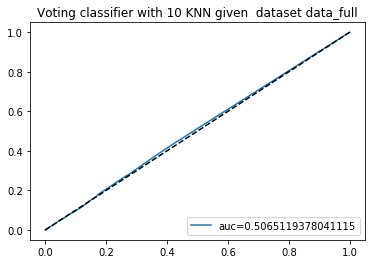

In [32]:
# ROC Curve
plt.plot(fpr,tpr,label="auc="+str(auc_knn_bag))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Voting classifier with 10 KNN given  dataset data_full')
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve:Voting classifier with 10 KNN given  dataset data_full: AP=0.08')

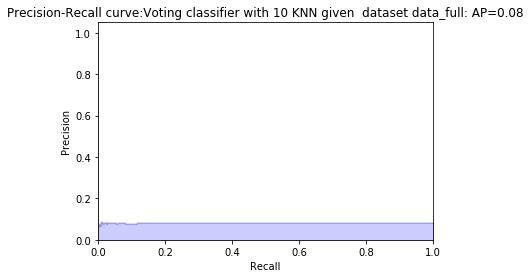

In [78]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_knn_bag)
average_precision = average_precision_score(y_test,y_pred_proba_knn_bag)
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:Voting classifier with 10 KNN given  dataset data_full: AP={0:0.2f}'.format(
          average_precision))

## 6.2 Voting Classifier: LightGBM

In [64]:
start_time_bag = time.clock()
bag = BaggingClassifier(lgbm,n_estimators=10,n_jobs=-1,random_state=0) # due to the memory issue, we can only use 30 estimators
bag.fit(X_resampled, y_resampled) 
end_time_bag=time.clock() - start_time_knn_bag
end_time_bag

10754.660219200001

In [65]:
start_time_bag = time.clock()
y_pred_bag = bag.predict(X_test)
end_time_bag=time.clock() - start_time_bag
print(end_time_bag)
accuracy_score(y_test,y_pred_bag)

48.865148099997896


0.9197370884616521

In [ ]:
# AUC Score
y_pred_proba_bag=eclf1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_bag)
auc_bag = metrics.roc_auc_score(y_test, y_pred_proba_bag)
auc_bag

In [68]:
# Confusion Matrix
confusion_matrix(y_pred_bag,y_test)

array([[93075,  7858],
       [  287,   259]], dtype=int64)

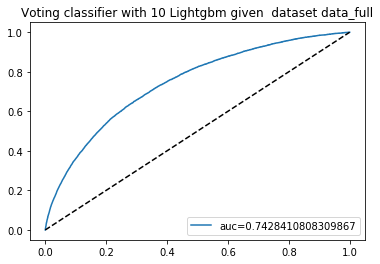

In [82]:
# ROC Curve
plt.plot(fpr,tpr,label="auc="+str(auc_bag))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Voting classifier with 10 Lightgbm given  dataset data_full')
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve:Voting classifier with 10 Lightgbm  given  dataset data_full: AP=0.22')

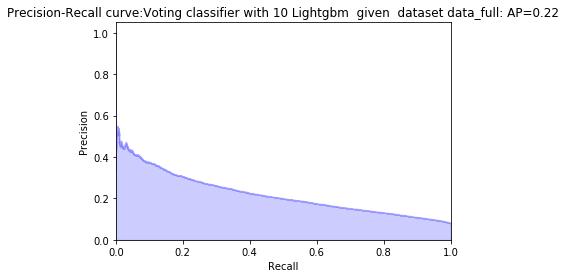

In [83]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_bag)
average_precision = average_precision_score(y_test,y_pred_proba_bag)
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:Voting classifier with 10 Lightgbm  given  dataset data_full: AP={0:0.2f}'.format(
          average_precision))

## 6.3 Voting Classifier: Random Forest & LightGBM

In [73]:
# RF with resampling
eclf1 = VotingClassifier(estimators=[ ('rf', rf), ('lgbm', lgbm),('sk_lgb',sk_lgb)], voting='soft')
eclf1.fit(X_resampled, y_resampled)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_...0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [69]:
# Confusion Matrix
confusion_matrix(y_pred_eclf,y_test)

array([[92914,  8079],
       [  448,    38]], dtype=int64)

In [74]:
# Accuracy Rate
start_time_eclf = time.clock()
y_pred_eclf = eclf1.predict(X_test)
end_time_eclf=time.clock() - start_time_eclf
print(end_time_eclf)
accuracy_score(y_test,y_pred_eclf)

5.698382599999604


0.9194020437726032

In [75]:
# AUC Score
y_pred_proba_eclf =eclf1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_eclf)
auc_knn_eclf = metrics.roc_auc_score(y_test, y_pred_proba_eclf)
auc_knn_eclf

0.7428410808309867

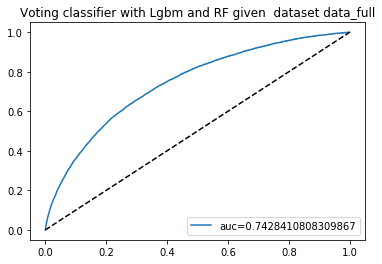

In [76]:
# ROC Curve
plt.plot(fpr,tpr,label="auc="+str(auc_knn_eclf))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Voting classifier with Lgbm and RF given  dataset data_full')
plt.legend(loc=4)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve:Voting classifier with Lgbm and RF given  dataset data_full: AP=0.22')

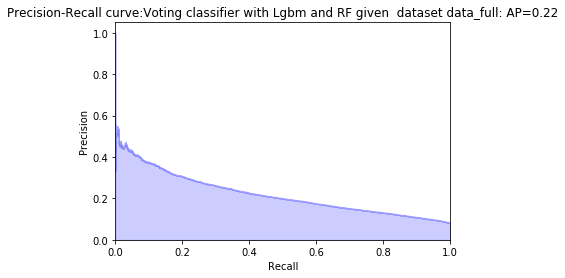

In [77]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_eclf)
average_precision = average_precision_score(y_test,y_pred_proba_eclf)
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:Voting classifier with Lgbm and RF given  dataset data_full: AP={0:0.2f}'.format(
          average_precision))